In [2]:
# Import libraries
import os
import glob
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import pandas as pd
import datetime as dt

In [4]:
# Set input directory, and change working directory
inDir = 'C:/Users/SASUKE/Desktop/NDVI_16day/MOD13Q1.006__250m_16_days_NDVI/'  # IMPORTANT: Update to reflect directory on your OS
os.chdir(inDir)                                                               # Change to working directory
outDir = os.path.normpath(os.path.split(inDir)[0] + os.sep + 'output') + '\\' # Create and set output directory
if not os.path.exists(outDir): os.makedirs(outDir)

In [5]:
EVIFiles = glob.glob('MOD13Q1.006__250m_16_days_NDVI_**.tif') # Search for and create a list of EVI files

In [26]:
print(len(EVIFiles))

35


In [6]:
EVI = gdal.Open(EVIFiles[0])                    # Read file in, starting with MOD13Q1 version 6
EVIBand = EVI.GetRasterBand(1)                  # Read the band (layer)
EVIData = EVIBand.ReadAsArray().astype('float') # Import band as an array with type float

In [7]:
print(EVIFiles[0])

MOD13Q1.006__250m_16_days_NDVI_doy2018353_aid0001.tif


In [8]:
# File name metadata:
productId = EVIFiles[0].split('_')[0]                                          # First: product name
layerId = EVIFiles[0].split(productId + '_')[1].split('_doy')[0]               # Second: layer name
yeardoy = EVIFiles[0].split(layerId+'_doy')[1].split('_aid')[0]                # Third: date
aid = EVIFiles[0].split(yeardoy+'_')[1].split('.tif')[0]                       # Fourth: unique ROI identifier (aid)
date = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%m/%d/%Y')              # Convert YYYYDDD to MM/DD/YYYY
print('Product Name: {}\nLayer Name: {}\nDate of Observation: {}'.format(productId, layerId, date))

Product Name: MOD13Q1.006
Layer Name: _250m_16_days_NDVI
Date of Observation: 12/19/2018


In [9]:
# File Metadata
EVI_meta = EVI.GetMetadata()                   # Store metadata in dictionary
rows, cols = EVI.RasterYSize, EVI.RasterXSize  # Number of rows,columns

# Projection information
geotransform = EVI.GetGeoTransform()
proj= EVI.GetProjection() 

# Band metadata
EVIFill = EVIBand.GetNoDataValue()            # Returns fill value
EVIStats = EVIBand.GetStatistics(True, True)  # returns min, max, mean, and standard deviation
EVI = None                                    # Close the GeoTIFF file
print('Min EVI: {}\nMax EVI: {}\nMean EVI: {}\nSD EVI: {}'.format(EVIStats[0],EVIStats[1], EVIStats[2], EVIStats[3]))

Min EVI: -1992.0
Max EVI: 9985.0
Mean EVI: 2973.296964191307
SD EVI: 2533.9403766918326


In [10]:
scaleFactor = float(EVI_meta['scale_factor'])  # Search the metadata dictionary for the scale factor 
units = EVI_meta['units']                      # Search the metadata dictionary for the units
EVIData[EVIData == EVIFill] = np.nan           # Set the fill value equal to NaN for the array
EVIScaled = EVIData * scaleFactor              # Apply the scale factor using simple multiplication

# Generate statistics on the scaled data
EVIStats_sc = [np.nanmin(EVIScaled), np.nanmax(EVIScaled), np.nanmean(EVIScaled), np.nanstd(EVIScaled)] # Create a list of stats
print('Min EVI: {}\nMax EVI: {}\nMean EVI: {}\nSD EVI: {}'.format(EVIStats_sc[0],EVIStats_sc[1], EVIStats_sc[2], EVIStats_sc[3]))

Min EVI: -0.2
Max EVI: 0.9994000000000001
Mean EVI: 0.29756010238540404
SD EVI: 0.25343066927598934


In [12]:
lut = glob.glob('**lookup.csv')                                        # Search for look up table 
qualityFiles =glob.glob('MOD13Q1.006__250m_16_days_VI_Quality**.tif')  # Search the directory for the associated quality .tifs
quality = gdal.Open(qualityFiles[0])                                   # Open the first quality file
qualityData = quality.GetRasterBand(1).ReadAsArray()                   # Read in as an array
quality = None                                                         # Close the quality file

In [13]:
v6_QA_lut = pd.read_csv(lut[0])     # Read in the lut
v6_QA_lut.head()                    # print the first few rows of the pandas dataframe

,Value,MODLAND,VI Usefulness,Aerosol Quantity,Adjacent cloud detected,Atmosphere BRDF Correction,Mixed Clouds,Land/Water Mask,Possible snow/ice,Possible shadow
0,13,"VI produced, but check other QA",Decreasing quality,Climatology,No,No,No,Shallow ocean,No,No
1,14,"Pixel produced, but most probably cloudy",Decreasing quality,Climatology,No,No,No,Shallow ocean,No,No
2,17,"VI produced, but check other QA",Decreasing quality,Climatology,No,No,No,Shallow ocean,No,No
3,18,"Pixel produced, but most probably cloudy",Decreasing quality,Climatology,No,No,No,Shallow ocean,No,No
4,21,"VI produced, but check other QA",Decreasing quality,Climatology,No,No,No,Shallow ocean,No,No


In [15]:
# Include good quality based on MODLAND
v6_QA_lut = v6_QA_lut[v6_QA_lut['MODLAND'].isin(['VI produced with good quality', 'VI produced, but check other QA'])]

# Exclude lower quality VI usefulness
VIU =["Lowest quality","Quality so low that it is not useful","L1B data faulty","Not useful for any other reason/not processed"]
v6_QA_lut = v6_QA_lut[~v6_QA_lut['VI Usefulness'].isin(VIU)]

v6_QA_lut = v6_QA_lut[v6_QA_lut['Aerosol Quantity'].isin(['Low','Average'])]   # Include low or average aerosol
v6_QA_lut = v6_QA_lut[v6_QA_lut['Adjacent cloud detected'] == 'No' ]           # Include where adjacent cloud not detected
v6_QA_lut = v6_QA_lut[v6_QA_lut['Mixed Clouds'] == 'No' ]                      # Include where mixed clouds not detected
v6_QA_lut = v6_QA_lut[v6_QA_lut['Possible shadow'] == 'No' ]                   # Include where possible shadow not detected
v6_QA_lut

,Value,MODLAND,VI Usefulness,Aerosol Quantity,Adjacent cloud detected,Atmosphere BRDF Correction,Mixed Clouds,Land/Water Mask,Possible snow/ice,Possible shadow
7,68,VI produced with good quality,Lower quality,Low,No,No,No,Shallow ocean,No,No
9,72,VI produced with good quality,Decreasing quality,Low,No,No,No,Shallow ocean,No,No
11,76,VI produced with good quality,Decreasing quality,Low,No,No,No,Shallow ocean,No,No
14,137,"VI produced, but check other QA",Decreasing quality,Average,No,No,No,Shallow ocean,No,No
16,141,"VI produced, but check other QA",Decreasing quality,Average,No,No,No,Shallow ocean,No,No
18,145,"VI produced, but check other QA",Decreasing quality,Average,No,No,No,Shallow ocean,No,No
70,2116,VI produced with good quality,Lower quality,Low,No,No,No,Land (Nothing else but land),No,No
72,2120,VI produced with good quality,Decreasing quality,Low,No,No,No,Land (Nothing else but land),No,No
74,2124,VI produced with good quality,Decreasing quality,Low,No,No,No,Land (Nothing else but land),No,No
77,2185,"VI produced, but check other QA",Decreasing quality,Average,No,No,No,Land (Nothing else but land),No,No


In [16]:
goodQuality = list(v6_QA_lut['Value']) # Retrieve list of possible QA values from the quality dataframe
print(goodQuality)

[68, 72, 76, 137, 141, 145, 2116, 2120, 2124, 2185, 2189, 2193, 4164, 4168, 4172, 4233, 4237, 4241, 6212, 6216, 6220, 6281, 6285, 6289, 18504, 18508, 18512, 18573, 18577, 18581, 20552, 20556, 20560, 20621, 20625, 20629, 22600, 22604, 22608, 22669, 22673, 22677]


In [17]:
EVI_masked = np.ma.MaskedArray(EVIScaled, np.in1d(qualityData, goodQuality, invert = True))    # Apply QA mask to the EVI data

In [18]:
# Set matplotlib plots inline
%matplotlib inline 

In [ ]:
EVIScaled

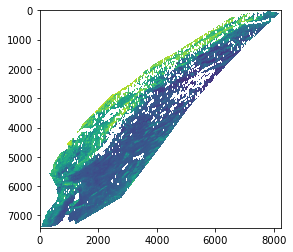

In [19]:
plt.imshow(EVIScaled);  # Visualize a basic plot of the scaled EVI data

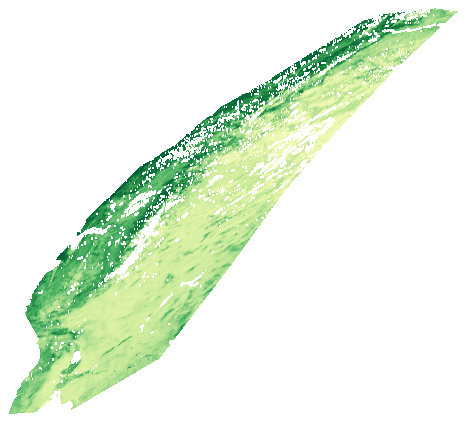

In [20]:
plt.figure(figsize = (10,7.5))    # Set the figure size (x,y)
plt.axis('off')                   # Remove the axes' values

# Plot the array, using a colormap and setting a custom linear stretch based on the min/max EVI values
plt.imshow(EVIScaled, vmin = np.nanmin(EVIScaled), vmax = np.nanmax(EVIScaled), cmap = 'YlGn');